In [848]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt  # Biblioteca para gerar gráficos
import pandas as pd
from sklearn import metrics, model_selection
from sklearn.cluster import KMeans as KMeans_
from scipy import stats
from scipy.spatial import distance
import math
import random

np.random.seed(666)

In [849]:

class Set:
    def __init__(self, dataset, features, output):
        self.dataset = dataset
        self.features = features
        self.output = output

    def get_n(self):
        return self.dataset.shape[0]

    def get_x(self):
        return self.dataset[:, self.features]
    
    def get_x_apply(self, func):
        return func(self.dataset[:, self.features])

    def set_x(self, new_x):
        self.x = new_x

    def get_y(self):
        return self.dataset[:, self.output]

    def get_X(self, func=None):
        if (func):
            return np.c_[np.ones(self.get_n()), func(self.get_x())]
        else:
            return np.c_[np.ones(self.get_n()), self.get_x()]


# Questão 1

**Observação**: Não esqueça de normalizar os dados em ambas as questões.

Considere o conjunto de dados disponível em **quake.csv**, organizado em 2 colunas de atributos. Os dados referem-se a latitudes e longitudes de locais em que foram registrados terremotos. Maiores detalhes sobre os dados podem ser conferidos em https://www.openml.org/d/772.

In [850]:
data = np.genfromtxt('./quake.csv', delimiter=',')

a) Avalie o algoritmo K-médias com distância Euclidiana na tarefa de agrupamento para tais dados. O número de grupos deve ser escolhido entre os valores 4,5,6,...19,20 a partir do índice DB (Davies-Bouldin). Plote o melhor resultado de agrupamento obtido.

**Observação**: Em cada avaliação repita múltiplas vezes (por exemplo, 20) a execução do algoritmo K-médias, escolhendo a solução com melhor erro de reconstrução.

In [855]:
def euclidean_distance(p, q, axis=0):
    return np.abs(np.sqrt(np.sum((p - q)**2, axis=axis)))

def cov(X):
    mu = np.mean(X, axis=0)
    aux = X - mu
    return (aux).T.dot(aux) / (X.shape[0])

def inverse_cov(X):
    cov_ = cov(X)
    return np.linalg.inv(cov_)

def mahalanobis_distance(x, u, vi):
    """vi: inversa da matriz de covariância dos dados de treino"""
    rs = (x - u).T
    rs = rs.dot(vi)
    rs = rs.dot((x - u))
    return np.sqrt(rs)

def rec_error(K, C):
    # print(C)
    sum = 0
    for k in range(K):
        for xi in C[k]:
            mk = np.mean(C[k])
            sum += euclidean_distance(xi, mk)
    return sum

def db_index(X, y_pred):
    K = len(np.bincount(y_pred))
    cluster_k = [X[y_pred == k] for k in range(K)]
    centroids = [np.mean(k, axis = 0) for k in cluster_k]
    within_cluster_scatter = [np.mean([euclidean_distance(p, centroids[i]) for p in k]) for i, k in enumerate(cluster_k)]
    db = []

    for k in range(K):
        db_kk = []
        for k_ in range(K):
            if k_ != k:
                between_cluster_distance = euclidean_distance(centroids[k], centroids[k_])
                eq = (within_cluster_scatter[k] + within_cluster_scatter[k_]) / between_cluster_distance
                db_kk.append(eq)
        db.append(max(db_kk))

    return np.mean(db)

class KMeans:    
    def __init__(self, n_clusters=4, distance_function='euclidean', VI=None):
        self.K = n_clusters
        self.distance_function = distance_function
        self.X = None
        self.VI = None
        self.distances = ['euclidean', 'mahalanobis']

        if distance_function not in self.distances:
            raise ValueError("for the distance_function parameter, please choose one of the following: %s" % (', '.join(self.distances)))
        
        if distance_function == 'mahalanobis':
            if VI is None:
                raise ValueError("for the mahalanobis distance, please supply the VI parameter")
            self.VI = VI
        
    def fit(self, X):
        self.X = X
        self.centroids = X[np.random.choice(len(X), self.K, replace=False)]
        self.intial_centroids = self.centroids
        self.prev_label, self.labels = None, np.zeros(len(X))
        while not np.all(self.labels == self.prev_label):
            self.prev_label = self.labels
            self.labels = self.predict(X)
            self.update_centroid(X)
        return self
        
    def predict(self, X):
        return np.apply_along_axis(self.classify, 1, X)

    def classify(self, x):
        if self.distance_function == 'euclidean':
            return np.argmin(euclidean_distance(self.centroids, x, axis=1))
        elif self.distance_function == 'mahalanobis':
            return np.argmin([mahalanobis_distance(centroid, x, self.VI) for centroid in self.centroids])
            # return np.argmin([distance.mahalanobis(centroid, x, self.VI) for centroid in self.centroids])
        else: 
            return None

    def update_centroid(self, X):
        self.centroids = np.array([np.mean(X[self.labels == k], axis=0)  for k in range(self.K)])

--- KMeans (euclidean)
best K: 18
best db_index: 0.63477
best rec error: 18.61350


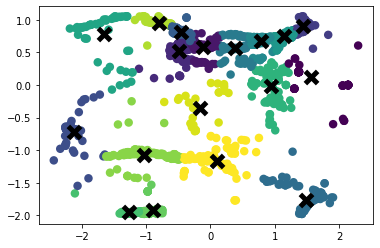

In [852]:
dataset = Set(data, [0, 1], 0)
X_ = dataset.get_x_apply(func=stats.zscore)

models = []
for K in range(4, 21):
    best_rec_error = None
    best_model = None

    for _ in range(20):
        kmeans = KMeans(K)
        kmeans.fit(X_)
        rec_error_ = rec_error(K, kmeans.centroids)
        if best_rec_error is None or rec_error_ < best_rec_error:
            best_rec_error = rec_error_
            best_model = kmeans
    
    models.append({'K': K, 'KMeans': best_model})

best_K = None
best_model = None
best_db_index = None
for model in models:
    y_pred = model['KMeans'].predict(X_)
    model_db_index = db_index(X_, y_pred)
    if best_db_index is None or model_db_index < best_db_index:
        best_K = model['K']
        best_model = model['KMeans']
        best_db_index = model_db_index

y_pred = best_model.predict(X_)

print('--- KMeans (euclidean)')
print("best K: %i" % best_K)
print("best db_index: %.5f" % (db_index(X_, y_pred)))
print("best rec error: %.5f" % (rec_error(best_K, best_model.centroids)))

plt.scatter(X_[:, 0], X_[:, 1], c=y_pred, s=30, linewidths=3)
for centroid in best_model.centroids:
    plt.scatter(centroid[0], centroid[1], marker="x", color="k", s=150, linewidths=5)
plt.show()

b) Repita o item anterior considerando a distância de Mahalanobis.

--- KMeans (mahalanobis)
best K: 4
best db_index: 0.58586
best rec error: 4.67024


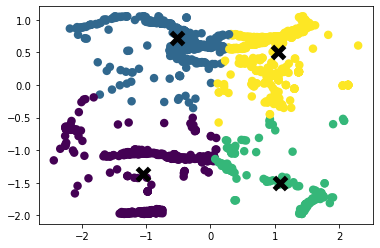

In [856]:
dataset = Set(data, [0, 1], 0)
X_ = dataset.get_x_apply(func=stats.zscore)
VI_ = inverse_cov(X_)

models = []
for K in range(4, 21):
    best_rec_error = None
    best_model = None

    for _ in range(20):
        kmeans = KMeans(K, 'mahalanobis', VI_)
        kmeans.fit(X_)
        rec_error_ = rec_error(K, kmeans.centroids)
        if best_rec_error is None or rec_error_ < best_rec_error:
            best_rec_error = rec_error_
            best_model = kmeans
    
    models.append({'K': K, 'KMeans': best_model})

best_K = None
best_model = None
best_db_index = None
for model in models:
    y_pred = model['KMeans'].predict(X_)
    model_db_index = db_index(X_, y_pred)
    if best_db_index is None or model_db_index < best_db_index:
        best_K = model['K']
        best_model = model['KMeans']
        best_db_index = model_db_index

y_pred = best_model.predict(X_)

print('--- KMeans (mahalanobis)')
print("best K: %i" % best_K)
print("best db_index: %.5f" % (db_index(X_, y_pred)))
print("best rec error: %.5f" % (rec_error(best_K, best_model.centroids)))

plt.scatter(X_[:, 0], X_[:, 1], c=y_pred, s=30, linewidths=3)
for centroid in best_model.centroids:
    plt.scatter(centroid[0], centroid[1], marker="x", color="k", s=150, linewidths=5)
plt.show()

# Questão 2

Considere o conjunto de dados disponível em **penguins.csv**, organizado em 5 colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados referem-se a medições anatômicas de pinguins da Antártida, classificados nas espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

In [857]:
data = np.genfromtxt('./penguins.csv', delimiter=',')
features = np.arange(4)
labels = 4

a) Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método PCA (análise dos componentes principais).

No handles with labels found to put in legend.


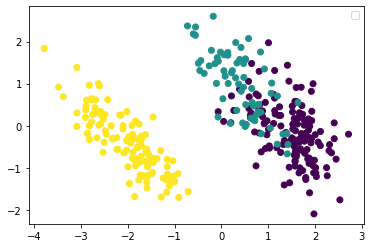

In [858]:
def PCA(X, num_components):
    X_meaned = X - np.mean(X, axis = 0)
    cov_mat = np.cov(X_meaned, rowvar = False)
    eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:, sorted_index]
    eigenvector_subset = sorted_eigenvectors[:, 0:num_components]
    X_reduced = np.dot(eigenvector_subset.transpose(), X_meaned.transpose()).transpose()
    return X_reduced

dataset = Set(data, features, labels)
X = dataset.get_x_apply(func=stats.zscore)
X = PCA(X, 2)

plt.scatter(X[:, 0], X[:, 1], c=dataset.get_y())
plt.legend()

b) Ainda considerando o item anterior, calcule e mostre a variância explicada obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

In [859]:
X = dataset.get_x_apply(func=stats.zscore)
X = PCA(X, 2)